In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt

from sklearn import svm, metrics, datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sma
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as sm

%matplotlib inline



In [2]:
df = pd.read_csv('train.csv')

dfi = df.set_index('PassengerId')

In [3]:
dfi.shape

(891, 11)

In [4]:
dfi.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
dfi.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
#Write a program that calculates the number of surviving passengers and prints it to the screen.

surv = dfi[dfi['Survived'] == 1].count()
surv.head(1)

Survived    342
dtype: int64

In [8]:
firstc = dfi[['Pclass', 'Survived']]
firstc_t = firstc[firstc['Pclass'] == 1]

t = firstc_t['Pclass'].value_counts()
f = firstc_t[firstc_t['Survived'] == 1]

perc = f['Survived'].value_counts() * 100 / t
perc

1    62.962963
dtype: float64

Text(0.5, 1.0, 'Survival of first class passengers')

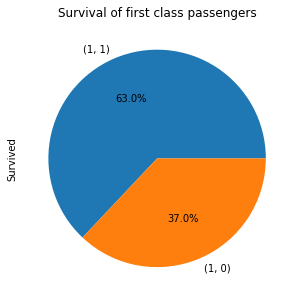

In [9]:
firstc_t.groupby('Pclass')['Survived'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5,5))
plt.title("Survival of first class passengers")

In [10]:
dfi['Age'].mean()

29.69911764705882

In [11]:
del dfi['Embarked']
del dfi['Cabin']
dfi1 = dfi.dropna()

In [12]:
ad, aa = dfi1.groupby('Survived')['Age'].mean()

In [13]:
dfi.reset_index(inplace=True)
dfi.set_index(['Survived'], inplace=True)
dfi['Age'].fillna({0:ad, 1:aa}, inplace=True)

Text(0.5, 1.0, 'surviving/dead passengers separated by class and gender')

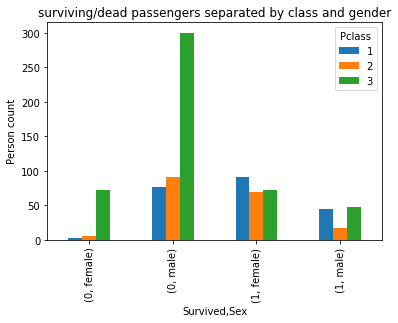

In [14]:
dfi.reset_index(inplace=True)
dfi.groupby(['Survived', 'Sex'])['Pclass'].value_counts().unstack().plot.bar()
plt.ylabel("Person count")
plt.title("surviving/dead passengers separated by class and gender")

# Feature Engineering

* normalizing --	de-mean, scale or otherwise transform features

* scaling 	-- shift the mean and standard deviation

* imputation 	-- fill missing values

* one-hot encoding 	-- convert categories to binary columns

* add features -- 	add extra polynomial or combined features

* feature selection --	decide which features to use

In [15]:
dfi.set_index('PassengerId', inplace=True)

Columns = Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare'

binary (hot coding) - Sex, Pclass, SibSP, Parch

normalizing - Fare, Age

In [16]:
dfi['Sex_bin'] = [1 if x =='male' else 0 for x in df['Sex']]

In [17]:
del dfi['Sex']
del dfi['Ticket']

In [18]:
Pc = dfi['Pclass']
Pclass_bin = pd.get_dummies(Pc)
Pclass_bin.columns = ['Pclass1', 'Pclass2', 'Pclass3']
dfi = pd.concat([dfi, Pclass_bin], axis=1)
del dfi['Pclass']

In [19]:
dfi['Age'] = dfi['Age'].apply(lambda x: x / dfi['Age'].sum())

In [20]:
dfi['Fare'] = dfi['Fare'].apply(lambda x: x / dfi['Fare'].sum())

In [21]:
dfi.head()

,Survived,Name,Age,SibSp,Parch,Fare,Sex_bin,Pclass1,Pclass2,Pclass3
PassengerId,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",0.000830,1,0,0.000253,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.001434,1,0,0.002484,0,1,0,0
3,1,"Heikkinen, Miss. Laina",0.000981,0,0,0.000276,0,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.001320,1,0,0.001851,0,1,0,0
5,0,"Allen, Mr. William Henry",0.001320,0,0,0.000281,1,0,0,1


# Logistic Regression

* sigmoid function --	function rapidly changing from 0 to 1
* coefficients --	model parameters in the linear part
* log probability --	result of the logistic function
* threshold value --	probability at which a positive prediction is made (default 0.5)
* log loss --	error function to be optimized
* one-vs-rest --	strategy for multinomial regression
* softmax --	error function for multinomial regression

In [22]:
X = dfi[['Age', 'SibSp', 'Parch', 'Fare', 'Sex_bin', 'Pclass1', 'Pclass2', 'Pclass3']]
y = dfi['Survived']

In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)

In [24]:
L = LogisticRegression(solver='newton-cg', C=688)
L.fit(Xtrain,ytrain)
L.score(Xtrain,ytrain)

0.8068862275449101

In [25]:
L.score(Xtest, ytest)

0.7982062780269058

In [26]:
L.coef_
# analysis which features have the most impact?

array([[-13.79886474,  -0.27124636,  -0.11955839,  12.0497878 ,
         -2.75082224,   0.85574893,   0.07964048,  -0.85675015]])

In [27]:
ypred = L.predict(Xtest)
metrics.confusion_matrix(ytest, ypred) # confusion matrix LR

array([[122,  16],
       [ 29,  56]])

In [28]:
logit = sm.Logit(y, X)
f = logit.fit()
print(f.params)
print(f.summary())

Optimization terminated successfully.
         Current function value: 0.440066
         Iterations 8
Age       -1134.436392
SibSp        -0.358412
Parch        -0.114157
Fare         83.847014
Sex_bin      -2.759882
Pclass1       3.975564
Pclass2       2.918606
Pclass3       1.779774
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:                  0.3392
Time:                        14:09:58   Log-Likelihood:                -392.10
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 7.089e-83
                 coef    std err          z      P>|z|      [0.025 

In [29]:
## implement random forest (print out?) 
# analysis which features have the most impact

In [30]:
m = RFC(n_estimators=10, max_depth=5)
m = m.fit(Xtrain,ytrain)
m.score(Xtrain,ytrain)

0.8562874251497006

In [31]:
m.score(Xtest,ytest)

0.8475336322869955

In [32]:
yp = m.predict(Xtest)
metrics.confusion_matrix(ytest, yp) # confusion matrix RFC

array([[127,  11],
       [ 23,  62]])

In [33]:
m.feature_importances_

array([0.17511924, 0.03623   , 0.04848585, 0.22535474, 0.37634866,
       0.05358455, 0.03261846, 0.0522585 ])

In [34]:
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=5)    
scores.mean()

0.8026154812402497

In [35]:
clf = svm.SVC(kernel='rbf', gamma=0.7, C = 1.0).fit(Xtrain, ytrain)
ypredicted = clf.predict(Xtest)

In [36]:
# calculate the fpr and tpr for all thresholds of the classification
probs = m.predict_proba(Xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9171781756180734

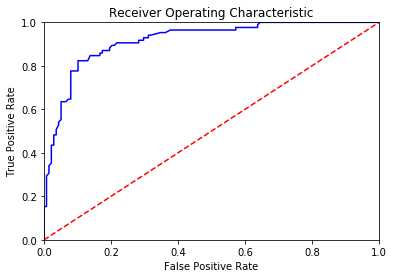

In [37]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
metrics.confusion_matrix(ytest, ypredicted) # confusion matrix SVM

array([[124,  14],
       [ 30,  55]])

<BarContainer object of 5 artists>

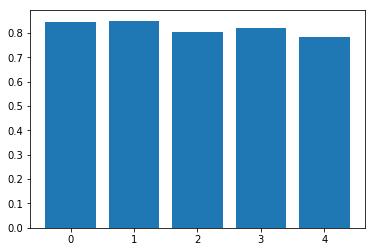

In [39]:
scores = cross_val_score(m, Xtrain, ytrain, cv=5)
plt.bar(range(5), scores)

In [40]:
bootstrapped = []

for i in range(1000):
    Xb, yb = resample(Xtrain, ytrain)
    m.fit(Xb, yb)
    score = m.score(Xb, yb)
    bootstrapped.append(score)
    
bootstrapped.sort()
ci80 = bootstrapped[100:-100]    # cuts off 10% of top and 10% of bottom

print("80% confidence interval: {} -{}".format(ci80[0], ci80[-1]))

80% confidence interval: 0.8562874251497006 -0.8952095808383234


In [41]:
LR = RandomizedSearchCV(L, {'C': range(700), 'solver':['newton-cg', 'lbfgs', 'liblinear']}, cv=3)

In [42]:
LR.fit(Xtrain,ytrain)
LR.score(Xtrain,ytrain)

0.8068862275449101

In [43]:
LR.score(Xtest, ytest)

0.7982062780269058

In [44]:
LR.best_params_

{'solver': 'newton-cg', 'C': 27}

# Prediction

In [45]:
dfpredict = pd.read_csv('predict.csv')

In [46]:
dfp = dfpredict.set_index(['PassengerId'])

In [47]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [48]:
age = dfp['Age'].mean()
dfp['Age'].fillna(age, inplace=True)

In [49]:
del dfp['Cabin']
del dfp['Embarked']
del dfp['Ticket']
del dfp['Name']

In [50]:
dfp['Fare'].fillna(0.0, inplace=True)
dfp['Sex_bin'] = [1 if x =='male' else 0 for x in dfp['Sex']]
del dfp['Sex']

In [51]:
Pc = dfp['Pclass']
Pclass_bin = pd.get_dummies(Pc)
Pclass_bin.columns = ['Pclass1', 'Pclass2', 'Pclass3']
dfp = pd.concat([dfp, Pclass_bin], axis=1)
del dfp['Pclass']

In [52]:
dfp['Age'] = dfp['Age'].apply(lambda x: x / dfp['Age'].sum())
dfp['Fare'] = dfp['Fare'].apply(lambda x: x / dfp['Fare'].sum())

In [53]:
dfp.head()

,Age,SibSp,Parch,Fare,Sex_bin,Pclass1,Pclass2,Pclass3
PassengerId,,,,,,,,
892,0.002726,0,0,0.000527,1,0,0,1
893,0.003714,1,0,0.000471,0,0,0,1
894,0.004900,0,0,0.000652,1,0,1,0
895,0.002134,0,0,0.000583,1,0,0,1
896,0.001739,1,1,0.000827,0,0,0,1


In [57]:
ypredict = L.predict(dfp)

In [59]:
dfp['Survived'] = ypredict

In [63]:
result = dfp[['Survived']]

In [65]:
result.to_csv('out.csv')